### Imports

In [3]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import subjects


### Peak ripple frequency distribution from early to late POST
- Since not much was revealed in mean/median wavelet spectrum for first vs third vs fifth hour of SD, I am trying to instead extract peak frequency for each ripple using wavelet and plot their distribution.
- In order to account for 1/f for wavelet spectrum, I had first bandpass (100-250 Hz) filtered the lfp but it still did not take care of 1/f comppletely.
- Currently, using whitened (statsmodels autoregression) signal to estimate peak frequencies. Works pretty well for estimating intraripple frequencies. However, there maybe some boundary effects for peak frequencies around 250 Hz. Maybe simply ignore these while doing analysis ??
- These code cells are not being used, Newer code cells (probably below this one) calculate peak ripple frequency for each ripple and saving those with ripple data.

In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal, Epoch
from neuropy.utils.signal_process import filter_sig
from hfuncs import whiten_signal

peak_f_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"].flatten()

    if np.diff(pre)[0] > 3600:
        pre_epoch = Epoch.from_array([pre[1] - 3600], [pre[1]], "pre")
    else:
        pre_epoch = Epoch.from_array([pre[0]], [pre[1]], "pre")

    zt = np.array([0, 2, 4, 5, 7])
    t_starts = zt * 3600 + post[0]
    epoch_labels = [f"Zt{i+1}" for i in zt]
    post_epochs = Epoch.from_array(t_starts, t_starts + 3600, epoch_labels)

    all_epochs = pre_epoch + maze + post_epochs
    all_labels = all_epochs.labels

    freqs = np.linspace(100, 250, 150)
    for t, label in zip(all_epochs.as_array(), all_labels):
        signal = sess.eegfile.get_signal(rpl_channels[sub], t[0], t[1] + 1)
        signal = whiten_signal(signal) 
        rpl_df = sess.ripple.time_slice(t[0], t[1]).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 125, p + 125) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t[0] * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        # filt_ = filter_sig.bandpass(new_sig, lf=100, hf=250)
        wvlt = WaveletSg(
            signal=new_sig,
            freqs=freqs,
            ncycles=10,
        ).traces

        peak_freqs = freqs[
            np.reshape(wvlt / np.sqrt(wvlt), (len(freqs), len(peakframe), -1))
            .max(axis=2)
            .argmax(axis=0)
        ]
        peak_f_df.append(pd.DataFrame({"f": peak_freqs, "t": label, "grp": sess.tag}))

peak_f_df = pd.concat(peak_f_df, ignore_index=True)
subjects.GroupData().save(peak_f_df, "ripple_peak_frequency")


In [ ]:
%matplotlib widget
from neuropy.plotting import plot_signal_heatmap
trace = new_sig.traces[0]
_,[ax1,ax2] = plt.subplots(2,1,sharex=True)
ax1.plot(trace)
ax2.imshow(wvlt,aspect='auto',cmap='jet',origin='lower',extent=[0,len(trace),freqs[0],freqs[-1]])

In [ ]:
%matplotlib widget
from scipy.ndimage import gaussian_filter1d
from neuropy.utils.signal_process import filter_sig
i=20
wvlt1 =  wvlt.reshape(len(freqs),len(peakframe),-1)[:,i,:]
wv_mean = np.mean(wvlt1,axis=1)
wv_zsc = stats.zscore(wvlt,axis=1)
wv_whiten1= wvlt1/wv_mean[:,np.newaxis]
sig = filt_.traces[0][250*i:250*i+250]
filt = filter_sig.bandpass(sig,lf=120,hf=250,fs=1250)

_,ax = plt.subplots(1,5)
ax[3].plot(sig)
ax[4].plot(filt)
ax[0].imshow(wvlt1,aspect='auto',cmap='jet')
ax[1].imshow(wv_whiten1,aspect='auto',cmap='jet')
ax[2].plot(freqs,wv_mean/np.sqrt(wv_mean))
# ax[2].plot(freqs,np.sum(wv_zsc,axis=1))
# ax[2].plot(freqs,np.sqrt(wv_mean))



In [ ]:
%matplotlib widget

# plt.imshow(wv_whiten,aspect='auto',cmap='jet',vmax=4)
_,ax = plt.subplots(1,3)
wv_whiten_ind = wv_whiten.reshape(len(freqs),len(peakframe),-1)
wv_traces = wvlt.traces.reshape(len(freqs),len(peakframe),-1)
ax[0].plot(freqs,wv_whiten_ind[:,1,:].mean(axis=1))
ax[0].plot(freqs,wv_traces[:,1,:].mean(axis=1)/10)
ax[1].imshow(wv_whiten_ind[:,1,:],aspect='auto')
ax[2].imshow(stats.zscore(wv_traces[:,1,:],axis=1),aspect='auto')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# colors = subjects.sd_colors.values()
colors = [subjects.sd.color(1.5),subjects.nsd.color(1.5)]

figure = plotting.Fig() 
fig,gs = figure.draw(grid=(4,2))
# sns.histplot(
#     data=peak_f_df,
#     x="f",
#     hue="t",
#     common_bins=True,
#     common_norm=False,
#     stat="probability",
#     # cumulative=True,
#     binwidth=10,
#     element='poly',
#     fill=False,
# )

ax = plt.subplot(gs[0])
v = sns.violinplot(
    data=peak_f_df,
    x="t",
    y='f',
    hue="grp",
    # estimator=np.median,
    # fill=False,
    # ci='sd',
    palette=colors,
    legend=None,
    marker='o',
    split=True,
    inner='quartile',
    linewidth=1,
    saturation=1,
    # alpha=0.5,
    # color='r',
    # dodge=True,
    # markersize=6,
    # err_style='bars',
    # err_kws={'capsize':3},
    ax=ax,
)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time')
ax.set_title('Peak ripple frequency')
# ax.grid(True)


# figure.savefig(subjects.figpath_sd/'ripple_peak_frequency_POST')

### Peak ripple frequency for each ripple and saving it in with ripple epochs
Tried two methods
- Using whitened signal --> wavelet --> max freq (Works really well)
- Using raw lfp --> wavelet --> divide wavelet by its sqrt to account for 1/f --> max freq (Works okayish) 

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday1
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
    + subjects.nsd.ratVday3
)
rpl_channels = [39,63,111,95,49,117,100,85,63,63,36,188,16,99,86,9]

assert len(rpl_channels)==len(sessions)


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal, Epoch
from neuropy.utils.signal_process import filter_sig
from hfuncs import whiten_signal

for sub, sess in enumerate(tqdm(sessions)):

    srate = sess.eegfile.sampling_rate
    duration = sess.eegfile.duration
    freqs = np.linspace(100, 250, 100)
    signal = sess.eegfile.get_signal(rpl_channels[sub])
    # lfp = whiten_signal(signal).traces[0]
    lfp = filter_sig.bandpass(signal,lf=100,hf=300).traces[0]
    # lfp = signal.traces[0]

    n_rpls = len(sess.ripple)
    rpls_window = np.arange(0, n_rpls, 1000)
    rpls_window[-1] = n_rpls

    peak_freqs = []
    for i in range(len(rpls_window) - 1):

        rpl_df = sess.ripple[rpls_window[i] : rpls_window[i + 1]].to_dataframe()
        peakframe = (rpl_df["peak_time"].values * srate).astype("int")

        rpl_frames = [np.arange(p - 125, p + 125) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames)
        # rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(lfp[rpl_frames].reshape(1, -1), sampling_rate=srate)

        wvlt = WaveletSg(
            signal=new_sig,
            freqs=freqs,
            ncycles=10,
        ).traces

        peak_freqs.append(
            freqs[
                np.reshape(wvlt, (len(freqs), len(peakframe), -1))
                .max(axis=2)
                .argmax(axis=0)
            ]
        )
    peak_freqs = np.concatenate(peak_freqs)

    assert len(peak_freqs)==len(sess.ripple)

    new_epochs = sess.ripple.add_column('peak_frequency_bp',peak_freqs)
    new_epochs.save(sess.filePrefix.with_suffix('.ripple'))

### Peak/Intra ripple frequency maze vs re-maze SD vs NSD

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)
rpl_channels = [95,49,100,85,188,16,99,86]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal, Epoch
from neuropy.utils.signal_process import filter_sig

peak_f_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"]
    re_maze = sess.paradigm['re-maze']
    epochs = maze + re_maze

    freqs = np.linspace(100, 250, 150)
    for t, label in zip(epochs.as_array(), epochs.labels):
        signal = sess.eegfile.get_signal(rpl_channels[sub], t[0], t[1]+1)
        rpl_df = sess.ripple.time_slice(t[0], t[1]).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 125, p + 125) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t[0] * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        filt_ = filter_sig.bandpass(new_sig,lf=100,hf=
        250)
        wvlt = WaveletSg(
            signal=filt_,
            freqs=freqs,
            ncycles=10,
        ).traces

        peak_freqs = freqs[
            np.reshape(wvlt/np.sqrt(wvlt), (len(freqs), len(peakframe), -1))
            .max(axis=2)
            .argmax(axis=0)
        ]
        peak_f_df = peak_f_df.append(
            pd.DataFrame({"f": peak_freqs, "t": label,'grp':sess.tag}), ignore_index=True
        )


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

colors = subjects.sd_colors.values()

figure = plotting.Fig() 
fig,gs = figure.draw(grid=(2,2))
# sns.histplot(
#     data=peak_f_df,
#     x="f",
#     hue="t",
#     common_bins=True,
#     common_norm=False,
#     stat="probability",
#     # cumulative=True,
#     binwidth=10,
#     element='poly',
#     fill=False,
# )

ax = plt.subplot(gs[0])
sns.violinplot(
    data=peak_f_df,
    x="t",
    y='f',
    hue="grp",
    # estimator=np.median,
    # fill=False,
    # ci='sd',
    palette=colors,
    marker='o',
    split=True,
    inner='quartile',
    # scale='width',
    # markersize=6,
    # err_style='bars',
    # err_kws={'capsize':3},
    legend=None,
    ax=ax,
)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time')
ax.set_title('Peak ripple frequency')

# figure.savefig(subjects.figpath_sd/'ripple_peak_frequency_maze_vs_re-maze')

### Ripple lfp autocorrelation slower vs faster ripples

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.ripple_sess()
# sessions = subjects.sd.ratSday3 + subjects.nsd.ratSday2
# rpl_channels = [95,188]
sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)
rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,16,99,86]

In [ ]:
import scipy.signal as sg
from statsmodels.tsa.stattools import acf
from neuropy.core import Epoch
from neuropy.utils.signal_process import filter_sig
from tqdm.notebook import tqdm
# peak_f_df = pd.DataFrame()
nlags=30
auto_corr_df=[]
for sub, sess in enumerate(tqdm(sessions)):
    post = sess.paradigm['post'].flatten()
    zt0to5=[post[0],post[0]+5*3600] 
    rpls_df = sess.ripple.time_slice(*zt0to5).to_dataframe()
    peaktime = rpls_df.peaktime
    epochs = Epoch.from_array(peaktime-0.1, peaktime+0.1) 

    srate = sess.eegfile.sampling_rate
    rpl_lfp = sess.eegfile.get_frames_within_epochs(epochs,rpl_channels[sub])
    rpl_filt = filter_sig.bandpass(rpl_lfp,lf=90,hf=300,fs=srate)
    auto_corr = acf(rpl_filt,nlags=nlags)
    auto_corr = np.concatenate((auto_corr[1:][::-1],auto_corr))

    lag_time = np.arange(-nlags,nlags+1)*(1000/srate) #milliseconds 
    df = pd.DataFrame(dict(lag_time=lag_time,auto_corr=auto_corr,grp=sess.tag))
    auto_corr_df.append(df)

auto_corr_df = pd.concat(auto_corr_df,ignore_index=True)
subjects.GroupData().save(auto_corr_df,'ripple_autocorr')

In [ ]:
%matplotlib widget
import seaborn as sns

sns.lineplot(data=auto_corr_df,x='lag_time',y='auto_corr',ci=None,hue='grp')

### Intraripple frequency distribution NSD vs SD

In [1]:
import numpy as np
import subjects 
import pandas as pd

sessions = subjects.nsd.ripple_sess + subjects.sd.ripple_sess

In [5]:
peak_f_df = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    # post_windows = np.arange(post[0], post[0] + 10 * 3600, 3600)
    # post_windows[-1] = np.min([post[1],post_windows[-1]])
    zts = np.array([0, 2.5, 5, 7.5])
    post_windows = zts * 3600 + post[0]
    post_epochs = np.vstack([post_windows[:-1], post_windows[1:]]).T
    post_labels = [f"{zts[_]}-{zts[_+1]}" for _ in range(len(zts) - 1)]

    epochs = np.vstack([pre, maze, post_epochs])
    epochs_labels = ["pre", "maze"]
    epochs_labels.extend(post_labels)

    for i, (w, label) in enumerate(zip(epochs, epochs_labels)):
        rpl_df = sess.ripple.time_slice(w[0], w[1]).to_dataframe()
        starts = rpl_df.start.values
        freqs = rpl_df.peak_frequency_bp.values

        peak_f_df.append(pd.DataFrame(dict(f=freqs, t=label, sub=sub, grp=sess.tag)))

peak_f_df = pd.concat(peak_f_df, ignore_index=True)
# peak_f_df = peak_f_df[peak_f_df.f<240].reset_index(drop=True) # takes care of some boundary effects
subjects.GroupData().save(peak_f_df, "ripple_peak_frequency")


ripple_peak_frequency saved


<AxesSubplot:xlabel='t', ylabel='f'>

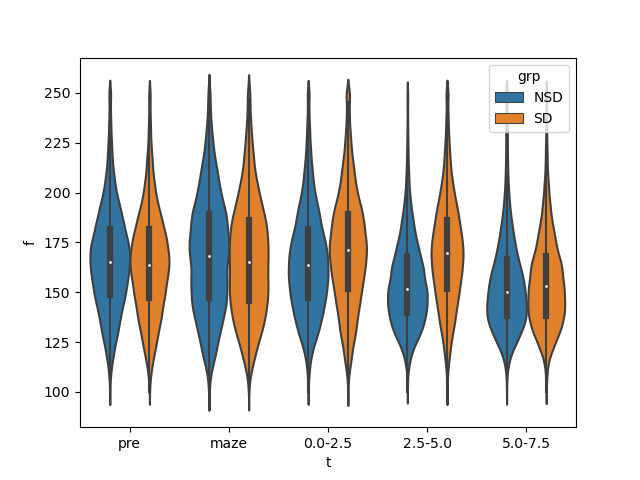

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# df = peak_f_df[peak_f_df.f<240]
_,ax = plt.subplots()
sns.violinplot(data=peak_f_df,x='t',y='f',hue='grp')

### Example spectrogram for slow and fast ripple

In [ ]:
import numpy as np
import subjects
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting import plot_signal_heatmap
from hfuncs import whiten_signal
from neuropy.core import Signal

sess = subjects.nsd.ratUday2[0]
chan = 100
signal = sess.eegfile.get_signal(chan)
# trace = whiten_signal(signal).traces[0]
trace = signal.traces[0]


In [ ]:
%matplotlib widget
from scipy import stats

rpl_df = sess.ripple.to_dataframe()
f = rpl_df.peak_frequency
peak_time = rpl_df.peaktime.values

slow_rpl_ind = np.random.default_rng().choice(np.where(f<170)[0]) # 9343,4616
# slow_rpl_ind = 4616 
fast_rpl_ind = np.random.default_rng().choice(np.where(f>180)[0]) # 1016,2800,907,974
# fast_rpl_ind = 974 
freqs = np.linspace(100,300,200)
n_frames = 150
dt = n_frames/1250
t = np.linspace(-dt,dt,2*n_frames)

_,axs = plt.subplots(1,2)
lfp_traces =[]
spects = []
for i,ind in enumerate([slow_rpl_ind,fast_rpl_ind]):
    peak_frame = int(peak_time[ind]*1250)
    f1,f2 = peak_frame-n_frames,peak_frame+n_frames

    new_trace = trace[f1:f2]
    new_sig = Signal(new_trace.reshape(1,-1),sampling_rate=1250)
    wvlt = WaveletSg(new_sig,freqs,ncycles=10).traces

    axs[i].pcolormesh(t,freqs,wvlt,cmap='hot')
    axs[i].axhline(f[ind],color='w',ls='--')
    ax2 = axs[i].twinx()
    ax2.plot(t,new_trace,'w')
    ax2.set_yticks([])
    lfp_traces.append(stats.zscore(new_trace))
    spects.append(wvlt)

data= dict(t=t,freqs=freqs,traces=lfp_traces,spects=spects)
# subjects.GroupData().save(data,'ripple_examples')

### Frequency and power distribution comparison between 1st and 5th hour of POST 
- both measures were calculated using wavelet transform
- Runs slow, maybe adding parallel loop for wavelet calculation will help, or move to hilbert amplitude which will be lot faster.
- **Results**: Hardly any changes to ripple power or frequency observed during sleep deprivation or recovery sleep

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat

rpl_power = pd.DataFrame()
rpl_freq_dist = pd.DataFrame()

for sub, sess in enumerate(sessions):
    print(sess.tag, sub)
    post = sess.paradigm["post"].flatten()
    # sd = sess.paradigm["sd"].flatten()
    sd = [post[0], post[0] + 5 * 3600]
    channels = sess.ripple.metadata["channels"]

    signal = sess.eegfile.get_signal(channels, 1800, 3600)
    hilbert_stat = hilbert_ampltiude_stat(
        signal.traces, freq_band=(150, 250), fs=1250, statistic="median"
    )

    channel = channels[np.argmax(hilbert_stat)]

    freqs = np.arange(130, 250, 2)
    rpls_1h = sess.ripple.time_slice(sd[0], sd[0] + 3600).set_labels("1st")
    rpls_5h = sess.ripple.time_slice(sd[0] + 4 * 3600, sd[1]).set_labels("5th")
    rpls_6h = sess.ripple.time_slice(sd[1], sd[1] + 3600).set_labels("6th")

    rpls_comb = rpls_1h + rpls_5h + rpls_6h
    max_power, freq_dist = [], []
    for start, stop in zip(rpls_comb.starts, rpls_comb.stops):
        signal = sess.eegfile.get_signal(channel, start, stop)
        wvlt = WaveletSg(signal=signal, freqs=freqs, ncycles=10)
        wvlt_mean = wvlt.mean_power()
        max_power.append(np.max(wvlt_mean))
        freq_dist.append(np.mean(wvlt.traces, axis=1))

    df1 = pd.DataFrame(
        {
            "max_power": np.array(max_power),
            "hour": rpls_comb.labels,
            "sub": sub,
            "grp": sess.tag,
        }
    )
    df2 = pd.DataFrame(np.asarray(freq_dist), columns=freqs)
    df2["hour"] = rpls_comb.labels
    df2["sub"] = sub
    df2["grp"] = sess.tag
    df2 = pd.melt(
        df2,
        id_vars=["hour", "sub", "grp"],
        value_vars=freqs,
        var_name=["freq"],
        value_name="freq_power",
        ignore_index=True,
    )

    rpl_power = rpl_power.append(df1).reset_index(drop=True)
    rpl_freq_dist = rpl_freq_dist.append(df2).reset_index(drop=True)


#### Frequency distribution plot

In [ ]:
%matplotlib widget
import seaborn as sns

dist = sns.relplot(
    data=rpl_freq_dist,
    x="freq",
    y='freq_power',
    hue="hour",
    ci=None,
    kind='line',
    row="sub",
    col='grp',
    height=1.5,
    aspect=2,
    lw=1,
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5.pdf')

#### Power distribution plot

In [ ]:
%matplotlib widget
from neuropy import plotting
import seaborn as sns

dist = sns.displot(
    data=rpl_power,
    x="max_power",
    hue="hour",
    stat="probability",
    # binrange=(0, 140),
    kind='hist',
    row="sub",
    col='grp',
    cumulative=False,
    # ax=ax,
    element="step",
    fill=False,
    common_norm=False,
    height=1.5,
    aspect=2,
    lw=1,
    # alpha=0.8,
    palette=['#5cc0eb','#faa49d','#05d69e'],
    
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5_vs_Zt6.pdf')
